## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp026'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    #backbone = 'se_resnext50_32x4d'
    backbone = 'timm-resnest50d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

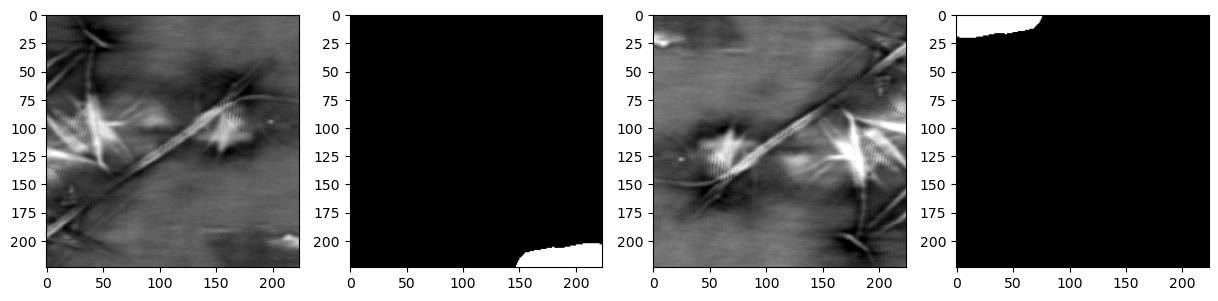

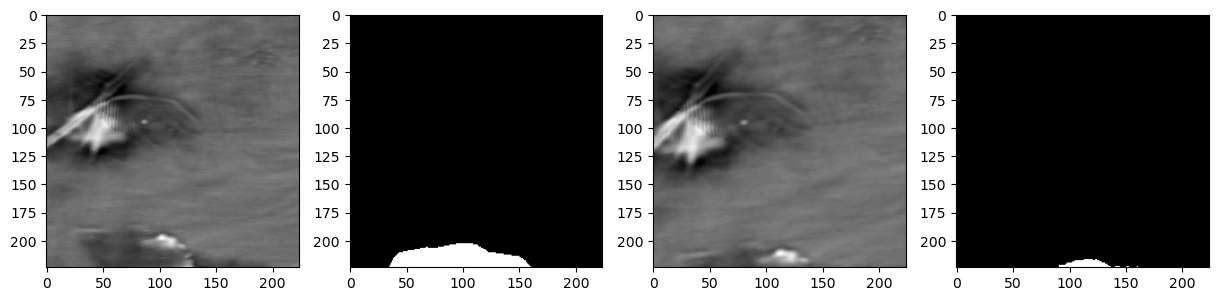

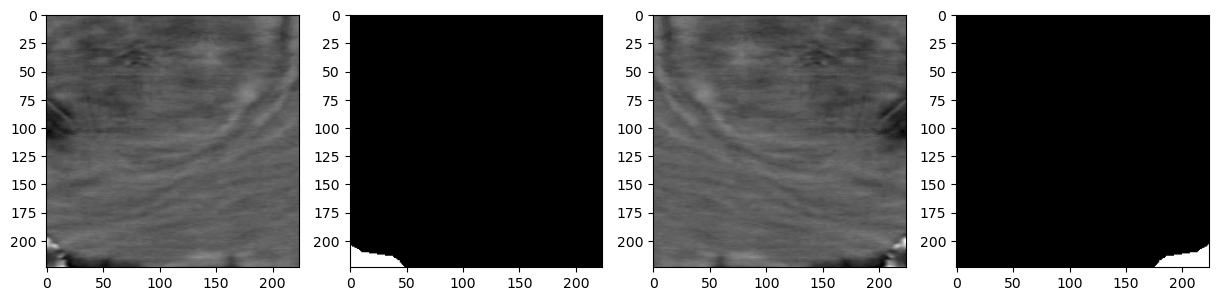

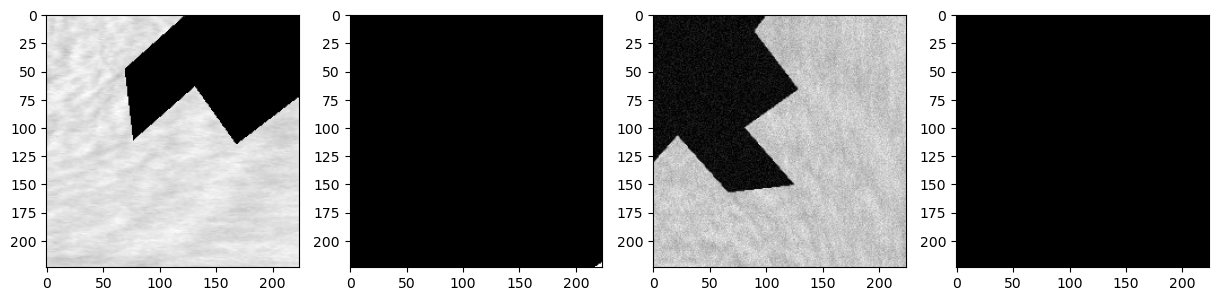

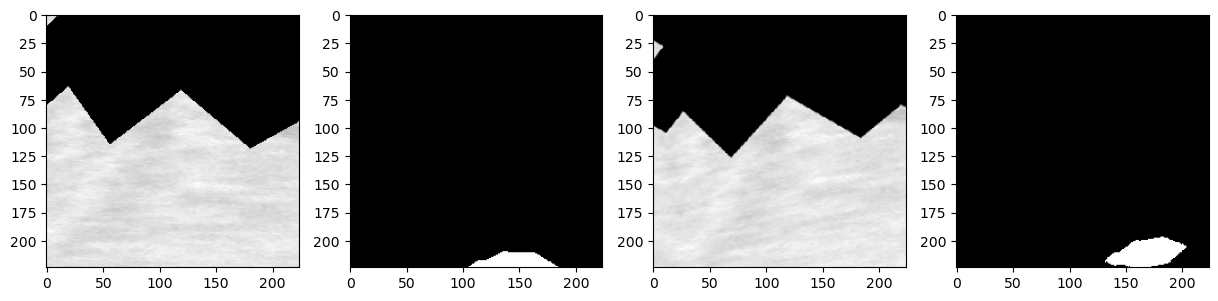

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48145

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone timm-resnest50d


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12118603348916249
th: 0.15, fbeta: 0.12189816947060715
th: 0.2, fbeta: 0.22157307027873832
th: 0.25, fbeta: 0.23916343326475595
th: 0.3, fbeta: 0.2600962372687532
th: 0.35, fbeta: 0.28702448357923677
th: 0.4, fbeta: 0.3203547674256465
th: 0.45, fbeta: 0.3494544999028832


best_th: 0.5, fbeta: 0.35386646794984017
Epoch 1 - avg_train_loss: 0.5696  avg_val_loss: 0.3800  time: 172s
Epoch 1 - avgScore: 0.3539
Epoch 1 - Save Best Score: 0.3539 Model
Epoch 1 - Save Best Loss: 0.3800 Model


th: 0.5, fbeta: 0.35386646794984017


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.19498699994504828
th: 0.15, fbeta: 0.23125589466003205
th: 0.2, fbeta: 0.2603166489674002
th: 0.25, fbeta: 0.31152040991553454
th: 0.3, fbeta: 0.36909121072710876
th: 0.35, fbeta: 0.40998154787578883
th: 0.4, fbeta: 0.43022641792830957
th: 0.45, fbeta: 0.4299611277585308


best_th: 0.4, fbeta: 0.43022641792830957
Epoch 2 - avg_train_loss: 0.3731  avg_val_loss: 0.3014  time: 177s
Epoch 2 - avgScore: 0.4302
Epoch 2 - Save Best Score: 0.4302 Model
Epoch 2 - Save Best Loss: 0.3014 Model


th: 0.5, fbeta: 0.40653967017790216


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.26650537348950115
th: 0.15, fbeta: 0.29944542358259946
th: 0.2, fbeta: 0.33359847331964076
th: 0.25, fbeta: 0.3631520907016346
th: 0.3, fbeta: 0.3904868377230327
th: 0.35, fbeta: 0.4146290220363692
th: 0.4, fbeta: 0.43505850567109455
th: 0.45, fbeta: 0.4468363600507759


best_th: 0.45, fbeta: 0.4468363600507759
Epoch 3 - avg_train_loss: 0.2883  avg_val_loss: 0.2416  time: 177s
Epoch 3 - avgScore: 0.4468
Epoch 3 - Save Best Score: 0.4468 Model
Epoch 3 - Save Best Loss: 0.2416 Model


th: 0.5, fbeta: 0.44609204269884256


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29813878140139094
th: 0.15, fbeta: 0.32761462146329373
th: 0.2, fbeta: 0.35319657697375556
th: 0.25, fbeta: 0.3810738636699817
th: 0.3, fbeta: 0.41129739587915554
th: 0.35, fbeta: 0.4359671583412511
th: 0.4, fbeta: 0.4486791132692972
th: 0.45, fbeta: 0.4530824570216813


best_th: 0.45, fbeta: 0.4530824570216813
Epoch 4 - avg_train_loss: 0.2525  avg_val_loss: 0.2402  time: 176s
Epoch 4 - avgScore: 0.4531
Epoch 4 - Save Best Score: 0.4531 Model
Epoch 4 - Save Best Loss: 0.2402 Model


th: 0.5, fbeta: 0.450580725122903


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29419730970710695
th: 0.15, fbeta: 0.33814905898068204
th: 0.2, fbeta: 0.36915505943821736
th: 0.25, fbeta: 0.3968819828570243
th: 0.3, fbeta: 0.4234737091901296
th: 0.35, fbeta: 0.4467140897288802
th: 0.4, fbeta: 0.465127764989136
th: 0.45, fbeta: 0.48329873731306455


best_th: 0.5, fbeta: 0.49225986410406897
Epoch 5 - avg_train_loss: 0.2459  avg_val_loss: 0.2331  time: 179s
Epoch 5 - avgScore: 0.4923
Epoch 5 - Save Best Score: 0.4923 Model
Epoch 5 - Save Best Loss: 0.2331 Model


th: 0.5, fbeta: 0.49225986410406897


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.370230220681126
th: 0.15, fbeta: 0.43005984865659447
th: 0.2, fbeta: 0.46494301145730577
th: 0.25, fbeta: 0.4925329505253691
th: 0.3, fbeta: 0.5118970055877562
th: 0.35, fbeta: 0.5230789078447008
th: 0.4, fbeta: 0.529030071482504
th: 0.45, fbeta: 0.5312169671450799


best_th: 0.45, fbeta: 0.5312169671450799
Epoch 6 - avg_train_loss: 0.2382  avg_val_loss: 0.2198  time: 179s
Epoch 6 - avgScore: 0.5312
Epoch 6 - Save Best Score: 0.5312 Model
Epoch 6 - Save Best Loss: 0.2198 Model


th: 0.5, fbeta: 0.5281206045945395


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3756993066869488
th: 0.15, fbeta: 0.4441441392802349
th: 0.2, fbeta: 0.4913878552575178
th: 0.25, fbeta: 0.522408538514732
th: 0.3, fbeta: 0.543921422180601
th: 0.35, fbeta: 0.5557634936366559
th: 0.4, fbeta: 0.5577522807697796
th: 0.45, fbeta: 0.5510463597196563


best_th: 0.4, fbeta: 0.5577522807697796
Epoch 7 - avg_train_loss: 0.2333  avg_val_loss: 0.2123  time: 178s
Epoch 7 - avgScore: 0.5578
Epoch 7 - Save Best Score: 0.5578 Model
Epoch 7 - Save Best Loss: 0.2123 Model


th: 0.5, fbeta: 0.5348104874557038


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3658258398851777
th: 0.15, fbeta: 0.3934054473893878
th: 0.2, fbeta: 0.4152214760563006
th: 0.25, fbeta: 0.43480153180966047
th: 0.3, fbeta: 0.4550032254517872
th: 0.35, fbeta: 0.4746580393447274
th: 0.4, fbeta: 0.4908238407995669
th: 0.45, fbeta: 0.5028291057968236


best_th: 0.5, fbeta: 0.5138481179281843
Epoch 8 - avg_train_loss: 0.2236  avg_val_loss: 0.2396  time: 179s
Epoch 8 - avgScore: 0.5138


th: 0.5, fbeta: 0.5138481179281843


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40596735737372247
th: 0.15, fbeta: 0.43712306634942594
th: 0.2, fbeta: 0.4626461631899905
th: 0.25, fbeta: 0.47839010024460454
th: 0.3, fbeta: 0.4971283940997017
th: 0.35, fbeta: 0.5088597250615007
th: 0.4, fbeta: 0.5105037082006563
th: 0.45, fbeta: 0.49979237815699873


best_th: 0.4, fbeta: 0.5105037082006563
Epoch 9 - avg_train_loss: 0.2139  avg_val_loss: 0.2457  time: 177s
Epoch 9 - avgScore: 0.5105


th: 0.5, fbeta: 0.4791001534782382


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33044808395242337
th: 0.15, fbeta: 0.36005587960134233
th: 0.2, fbeta: 0.3814633536317342
th: 0.25, fbeta: 0.40075378570702785
th: 0.3, fbeta: 0.41673224623337324
th: 0.35, fbeta: 0.42982088520579115
th: 0.4, fbeta: 0.44214045938907304
th: 0.45, fbeta: 0.45617218203026483


best_th: 0.5, fbeta: 0.4713180242295297
Epoch 10 - avg_train_loss: 0.2040  avg_val_loss: 0.2482  time: 178s
Epoch 10 - avgScore: 0.4713


th: 0.5, fbeta: 0.4713180242295297


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4276875758692295
th: 0.15, fbeta: 0.4645976112780284
th: 0.2, fbeta: 0.48815502695180923
th: 0.25, fbeta: 0.5034409741192678
th: 0.3, fbeta: 0.5086290568065445
th: 0.35, fbeta: 0.5084437630865433
th: 0.4, fbeta: 0.5035194669290044
th: 0.45, fbeta: 0.4901289066108327


best_th: 0.3, fbeta: 0.5086290568065445
Epoch 11 - avg_train_loss: 0.2010  avg_val_loss: 0.2461  time: 180s
Epoch 11 - avgScore: 0.5086


th: 0.5, fbeta: 0.4719835474947579


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3741945474785217
th: 0.15, fbeta: 0.41699175555519413
th: 0.2, fbeta: 0.4496781710508624
th: 0.25, fbeta: 0.47428115819891936
th: 0.3, fbeta: 0.49480198477826537
th: 0.35, fbeta: 0.5118889797230233
th: 0.4, fbeta: 0.5245164932739964
th: 0.45, fbeta: 0.5340894967535662


best_th: 0.5, fbeta: 0.5369815770143578
Epoch 12 - avg_train_loss: 0.1965  avg_val_loss: 0.2288  time: 180s
Epoch 12 - avgScore: 0.5370


th: 0.5, fbeta: 0.5369815770143578


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3540926634537843
th: 0.15, fbeta: 0.38365289694591076
th: 0.2, fbeta: 0.4121166502240844
th: 0.25, fbeta: 0.4386777980273622
th: 0.3, fbeta: 0.45796861934060096
th: 0.35, fbeta: 0.4701936425622087
th: 0.4, fbeta: 0.4785277070661642
th: 0.45, fbeta: 0.48456587444955096


best_th: 0.5, fbeta: 0.4881661438619864
Epoch 13 - avg_train_loss: 0.1776  avg_val_loss: 0.2613  time: 178s
Epoch 13 - avgScore: 0.4882


th: 0.5, fbeta: 0.4881661438619864


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37909630425667207
th: 0.15, fbeta: 0.417038737758034
th: 0.2, fbeta: 0.4441451053164135
th: 0.25, fbeta: 0.46680648665704594
th: 0.3, fbeta: 0.48515990500920064
th: 0.35, fbeta: 0.5005625318829476
th: 0.4, fbeta: 0.5146899280766633
th: 0.45, fbeta: 0.5252722625099471


best_th: 0.5, fbeta: 0.5314284942400239
Epoch 14 - avg_train_loss: 0.1737  avg_val_loss: 0.2398  time: 177s
Epoch 14 - avgScore: 0.5314


th: 0.5, fbeta: 0.5314284942400239


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3613142299009577
th: 0.15, fbeta: 0.39569955226042886
th: 0.2, fbeta: 0.4229757743213236
th: 0.25, fbeta: 0.44521830691524733
th: 0.3, fbeta: 0.46543587490708394
th: 0.35, fbeta: 0.4823086481076933
th: 0.4, fbeta: 0.49631274016958754
th: 0.45, fbeta: 0.5101138126464216


best_th: 0.5, fbeta: 0.5224248297435728
Epoch 15 - avg_train_loss: 0.1588  avg_val_loss: 0.2441  time: 178s
Epoch 15 - avgScore: 0.5224


th: 0.5, fbeta: 0.5224248297435728


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39991913115696115
th: 0.15, fbeta: 0.43013516101072585
th: 0.2, fbeta: 0.45517919164560167
th: 0.25, fbeta: 0.4769096538829532
th: 0.3, fbeta: 0.4937613952652315
th: 0.35, fbeta: 0.5091208356300703
th: 0.4, fbeta: 0.5227744735837307
th: 0.45, fbeta: 0.5349049584161665


best_th: 0.5, fbeta: 0.5414150425784571
Epoch 16 - avg_train_loss: 0.1519  avg_val_loss: 0.2684  time: 179s
Epoch 16 - avgScore: 0.5414


th: 0.5, fbeta: 0.5414150425784571


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40578189768923084
th: 0.15, fbeta: 0.4268679058990814
th: 0.2, fbeta: 0.4399843588250384
th: 0.25, fbeta: 0.44712937143772585
th: 0.3, fbeta: 0.44936560466161485
th: 0.35, fbeta: 0.4474858957558914
th: 0.4, fbeta: 0.44561659800521475
th: 0.45, fbeta: 0.4420386947900764


best_th: 0.3, fbeta: 0.44936560466161485
Epoch 17 - avg_train_loss: 0.1529  avg_val_loss: 0.2993  time: 178s
Epoch 17 - avgScore: 0.4494


th: 0.5, fbeta: 0.43301712034583884


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4020113637793183
th: 0.15, fbeta: 0.433288351675003
th: 0.2, fbeta: 0.45627122728924213
th: 0.25, fbeta: 0.47455562962822995
th: 0.3, fbeta: 0.49142153649782533
th: 0.35, fbeta: 0.503737937836868
th: 0.4, fbeta: 0.5139182504109943
th: 0.45, fbeta: 0.5220687439947757


best_th: 0.5, fbeta: 0.5223828757366337
Epoch 18 - avg_train_loss: 0.1398  avg_val_loss: 0.2642  time: 178s
Epoch 18 - avgScore: 0.5224


th: 0.5, fbeta: 0.5223828757366337


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39009857444325874
th: 0.15, fbeta: 0.41923815838795353
th: 0.2, fbeta: 0.4404472862081898
th: 0.25, fbeta: 0.4568152130182327
th: 0.3, fbeta: 0.47038188291784067
th: 0.35, fbeta: 0.4822116377954564
th: 0.4, fbeta: 0.49188819971642217
th: 0.45, fbeta: 0.49976205865316753


best_th: 0.5, fbeta: 0.5021349709113615
Epoch 19 - avg_train_loss: 0.1349  avg_val_loss: 0.2879  time: 176s
Epoch 19 - avgScore: 0.5021


th: 0.5, fbeta: 0.5021349709113615


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43579699205599154
th: 0.15, fbeta: 0.46832524649475055
th: 0.2, fbeta: 0.489195517971171
th: 0.25, fbeta: 0.5030805342284275
th: 0.3, fbeta: 0.5096911100705231
th: 0.35, fbeta: 0.512001698237413
th: 0.4, fbeta: 0.5136456329784752
th: 0.45, fbeta: 0.5134844059042908


best_th: 0.4, fbeta: 0.5136456329784752
Epoch 20 - avg_train_loss: 0.1253  avg_val_loss: 0.2938  time: 179s
Epoch 20 - avgScore: 0.5136


th: 0.5, fbeta: 0.5109274354945947


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3765111191660494
th: 0.15, fbeta: 0.40767753968928405
th: 0.2, fbeta: 0.4339013428466575
th: 0.25, fbeta: 0.4536691548362373
th: 0.3, fbeta: 0.4682399512749854
th: 0.35, fbeta: 0.4801294584043068
th: 0.4, fbeta: 0.4885842488012044
th: 0.45, fbeta: 0.49638994470592085


best_th: 0.5, fbeta: 0.4994938404022207
Epoch 21 - avg_train_loss: 0.1195  avg_val_loss: 0.2814  time: 180s
Epoch 21 - avgScore: 0.4995


th: 0.5, fbeta: 0.4994938404022207


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42341832602736296
th: 0.15, fbeta: 0.4588424051842929
th: 0.2, fbeta: 0.48474265280566775
th: 0.25, fbeta: 0.5045334563477395
th: 0.3, fbeta: 0.5185931481894872
th: 0.35, fbeta: 0.5284067245473936
th: 0.4, fbeta: 0.534847859632014
th: 0.45, fbeta: 0.5390190883358031


best_th: 0.5, fbeta: 0.540891114027609
Epoch 22 - avg_train_loss: 0.1115  avg_val_loss: 0.2889  time: 182s
Epoch 22 - avgScore: 0.5409


th: 0.5, fbeta: 0.540891114027609


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43899579950318335
th: 0.15, fbeta: 0.47797438589061586
th: 0.2, fbeta: 0.508651678124827
th: 0.25, fbeta: 0.5325401367433141
th: 0.3, fbeta: 0.5484580082165441
th: 0.35, fbeta: 0.5586549850305234
th: 0.4, fbeta: 0.5666079877456383
th: 0.45, fbeta: 0.5721793159908664


best_th: 0.5, fbeta: 0.5743680504267166
Epoch 23 - avg_train_loss: 0.1077  avg_val_loss: 0.2779  time: 179s
Epoch 23 - avgScore: 0.5744
Epoch 23 - Save Best Score: 0.5744 Model
Epoch 23 - Save Best Loss: 0.2779 Model


th: 0.5, fbeta: 0.5743680504267166


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40848732830763995
th: 0.15, fbeta: 0.43780372689822533
th: 0.2, fbeta: 0.4621174487881536
th: 0.25, fbeta: 0.4826356487295092
th: 0.3, fbeta: 0.4975279955853143
th: 0.35, fbeta: 0.5088328072824356
th: 0.4, fbeta: 0.5167950711181512
th: 0.45, fbeta: 0.5208525617766708


best_th: 0.5, fbeta: 0.5220251903034157
Epoch 24 - avg_train_loss: 0.1025  avg_val_loss: 0.2876  time: 181s
Epoch 24 - avgScore: 0.5220


th: 0.5, fbeta: 0.5220251903034157


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4523920597911412
th: 0.15, fbeta: 0.4786926051359847
th: 0.2, fbeta: 0.5006875645411741
th: 0.25, fbeta: 0.5176060925869171
th: 0.3, fbeta: 0.527371416454734
th: 0.35, fbeta: 0.534372861861532
th: 0.4, fbeta: 0.5410156607352485
th: 0.45, fbeta: 0.5433974980588173


best_th: 0.45, fbeta: 0.5433974980588173
Epoch 25 - avg_train_loss: 0.0984  avg_val_loss: 0.3058  time: 178s
Epoch 25 - avgScore: 0.5434


th: 0.5, fbeta: 0.542357051914408


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4666004153711563
th: 0.15, fbeta: 0.4931784841061011
th: 0.2, fbeta: 0.5112366887574686
th: 0.25, fbeta: 0.5232464438928272
th: 0.3, fbeta: 0.5305546874691375
th: 0.35, fbeta: 0.5365366291743304
th: 0.4, fbeta: 0.5392572581581134
th: 0.45, fbeta: 0.535613367485533


best_th: 0.4, fbeta: 0.5392572581581134
Epoch 26 - avg_train_loss: 0.0956  avg_val_loss: 0.3116  time: 179s
Epoch 26 - avgScore: 0.5393


th: 0.5, fbeta: 0.5297533528520035


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46399659705801793
th: 0.15, fbeta: 0.4899284674746384
th: 0.2, fbeta: 0.505757426675919
th: 0.25, fbeta: 0.5197408611160663
th: 0.3, fbeta: 0.5271246581951107
th: 0.35, fbeta: 0.5304619083826292
th: 0.4, fbeta: 0.531807852184809
th: 0.45, fbeta: 0.5293844600131792


best_th: 0.4, fbeta: 0.531807852184809
Epoch 27 - avg_train_loss: 0.0905  avg_val_loss: 0.3268  time: 178s
Epoch 27 - avgScore: 0.5318


th: 0.5, fbeta: 0.5241311117696118


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.473226405932461
th: 0.15, fbeta: 0.4979665944867846
th: 0.2, fbeta: 0.5144175972308436
th: 0.25, fbeta: 0.5240751800981464
th: 0.3, fbeta: 0.527231716944298
th: 0.35, fbeta: 0.5289035865379264
th: 0.4, fbeta: 0.5277968256594615
th: 0.45, fbeta: 0.5254363261414364


best_th: 0.35, fbeta: 0.5289035865379264
Epoch 28 - avg_train_loss: 0.0908  avg_val_loss: 0.3256  time: 177s
Epoch 28 - avgScore: 0.5289


th: 0.5, fbeta: 0.5169898930114487


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47165948776028743
th: 0.15, fbeta: 0.49556818532698854
th: 0.2, fbeta: 0.5115726475830957
th: 0.25, fbeta: 0.5237031683019175
th: 0.3, fbeta: 0.5295044771148042
th: 0.35, fbeta: 0.5311631312527495
th: 0.4, fbeta: 0.5305058626355327
th: 0.45, fbeta: 0.5267397609463617


best_th: 0.35, fbeta: 0.5311631312527495
Epoch 29 - avg_train_loss: 0.0878  avg_val_loss: 0.3332  time: 178s
Epoch 29 - avgScore: 0.5312


th: 0.5, fbeta: 0.5208097904255679


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4674570945100277
th: 0.15, fbeta: 0.49436422260237517
th: 0.2, fbeta: 0.5115011202597769
th: 0.25, fbeta: 0.5234690530573445
th: 0.3, fbeta: 0.528490096539447
th: 0.35, fbeta: 0.5287861269534889
th: 0.4, fbeta: 0.5285591287366022
th: 0.45, fbeta: 0.5261815636906345


best_th: 0.35, fbeta: 0.5287861269534889
Epoch 30 - avg_train_loss: 0.0857  avg_val_loss: 0.3224  time: 178s
Epoch 30 - avgScore: 0.5288


th: 0.5, fbeta: 0.5204940642056457


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.43899579950318335
th: 0.15, fbeta: 0.47797438589061586
th: 0.2, fbeta: 0.508651678124827
th: 0.25, fbeta: 0.5325401367433141
th: 0.3, fbeta: 0.5484580082165441
th: 0.35, fbeta: 0.5586549850305234
th: 0.4, fbeta: 0.5666079877456383
th: 0.45, fbeta: 0.5721793159908664


best_th: 0.5, fbeta: 0.5743680504267166


th: 0.5, fbeta: 0.5743680504267166


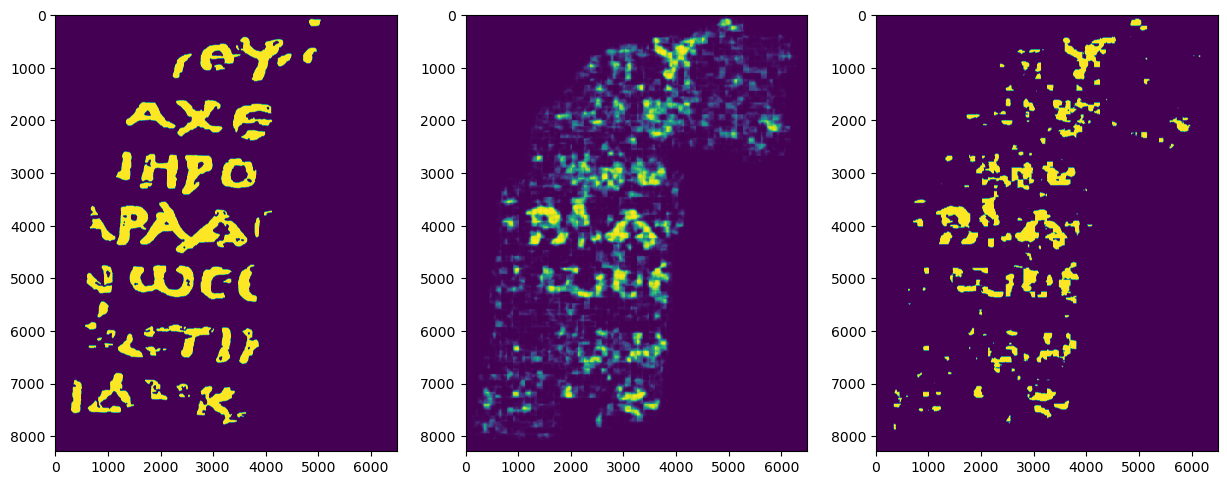

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([41792372.,  2781073.,  1638951.,  1121938.,   865866.,   666781.,
          547289.,   479795.,   435285.,   396584.,   361896.,   323335.,
          296566.,   285628.,   274990.,   259577.,   278984.,   312455.,
          349208.,   370275.]),
 array([3.56206402e-06, 4.99529607e-02, 9.99023593e-02, 1.49851758e-01,
        1.99801156e-01, 2.49750555e-01, 2.99699954e-01, 3.49649352e-01,
        3.99598751e-01, 4.49548149e-01, 4.99497548e-01, 5.49446947e-01,
        5.99396345e-01, 6.49345744e-01, 6.99295142e-01, 7.49244541e-01,
        7.99193940e-01, 8.49143338e-01, 8.99092737e-01, 9.49042136e-01,
        9.98991534e-01]),
 <BarContainer object of 20 artists>)

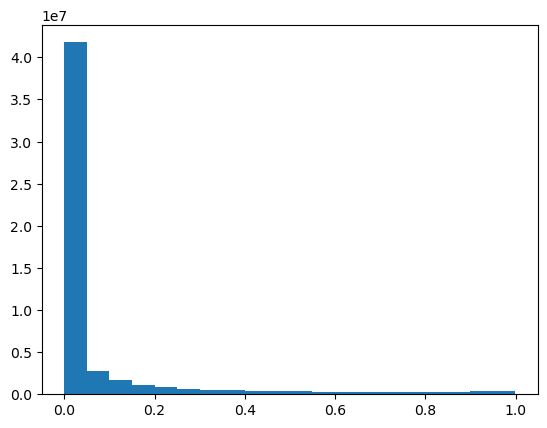

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000